In [34]:
import torch
import lightning as L
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import itertools
import math
import torch.nn as nn
import numpy as np
import torch.optim as optim
import pytorch_lightning as L
import seaborn as sns
import os
import torch.nn.functional as F

from typing import Any
from abc import ABC, abstractmethod
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.nn import functional
from torchvision.transforms import ToTensor
from torch.optim.optimizer import Optimizer
from lightning.pytorch.loggers import CSVLogger
from glob import glob
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, Normalize, RandomHorizontalFlip, RandomRotation
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import Optimizer
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from tabulate import tabulate
from IPython.display import display
from pytorch_lightning.loggers import CSVLogger

In [13]:
RANDOM_SEED = 777
WORKERS = 2
BATCH_SIZE = 64
VAL_SIZE = 0.2

Train: 48000, Val: 12000, Test: 10000


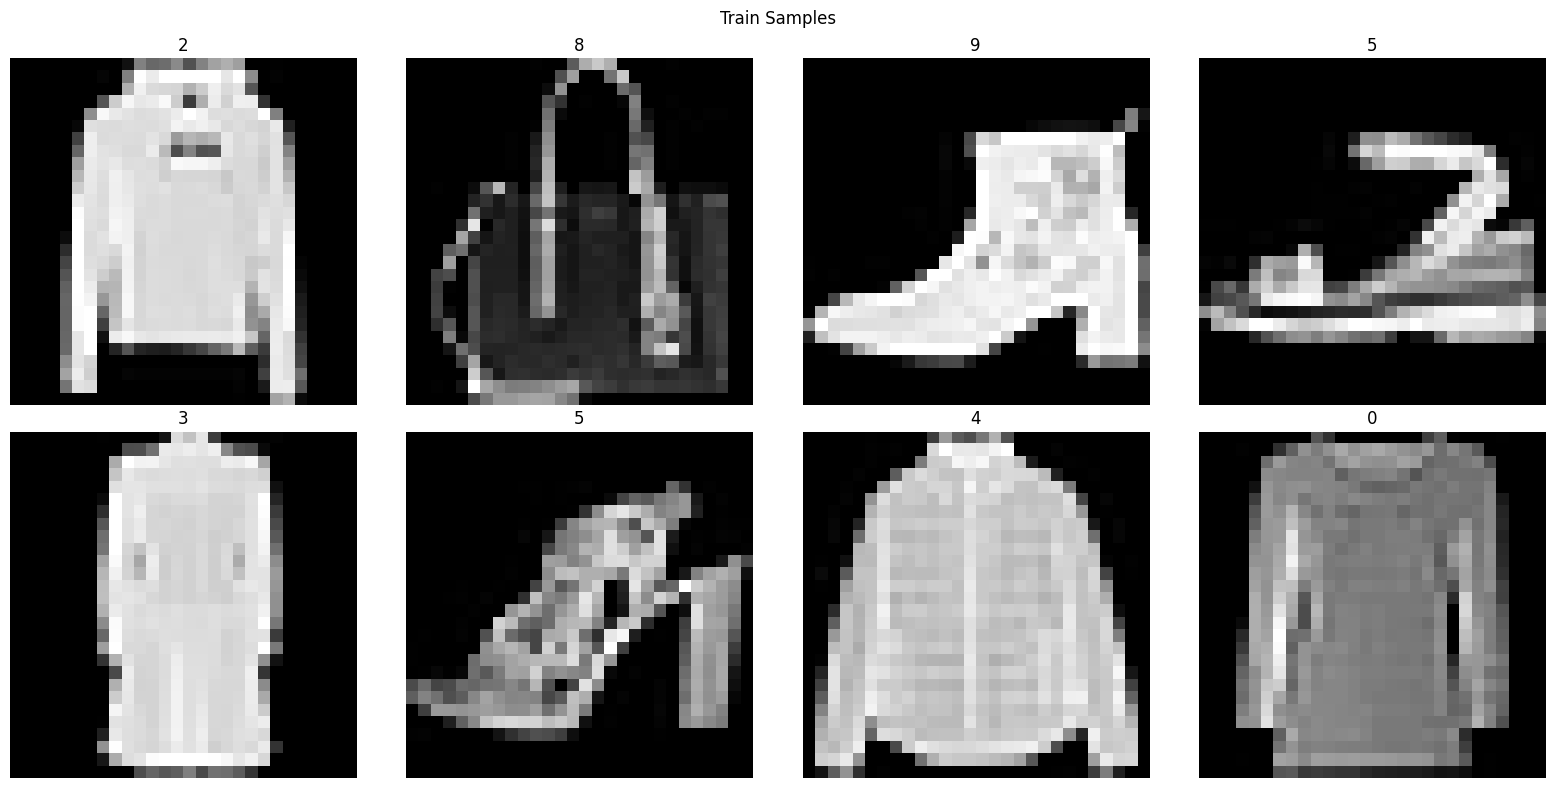

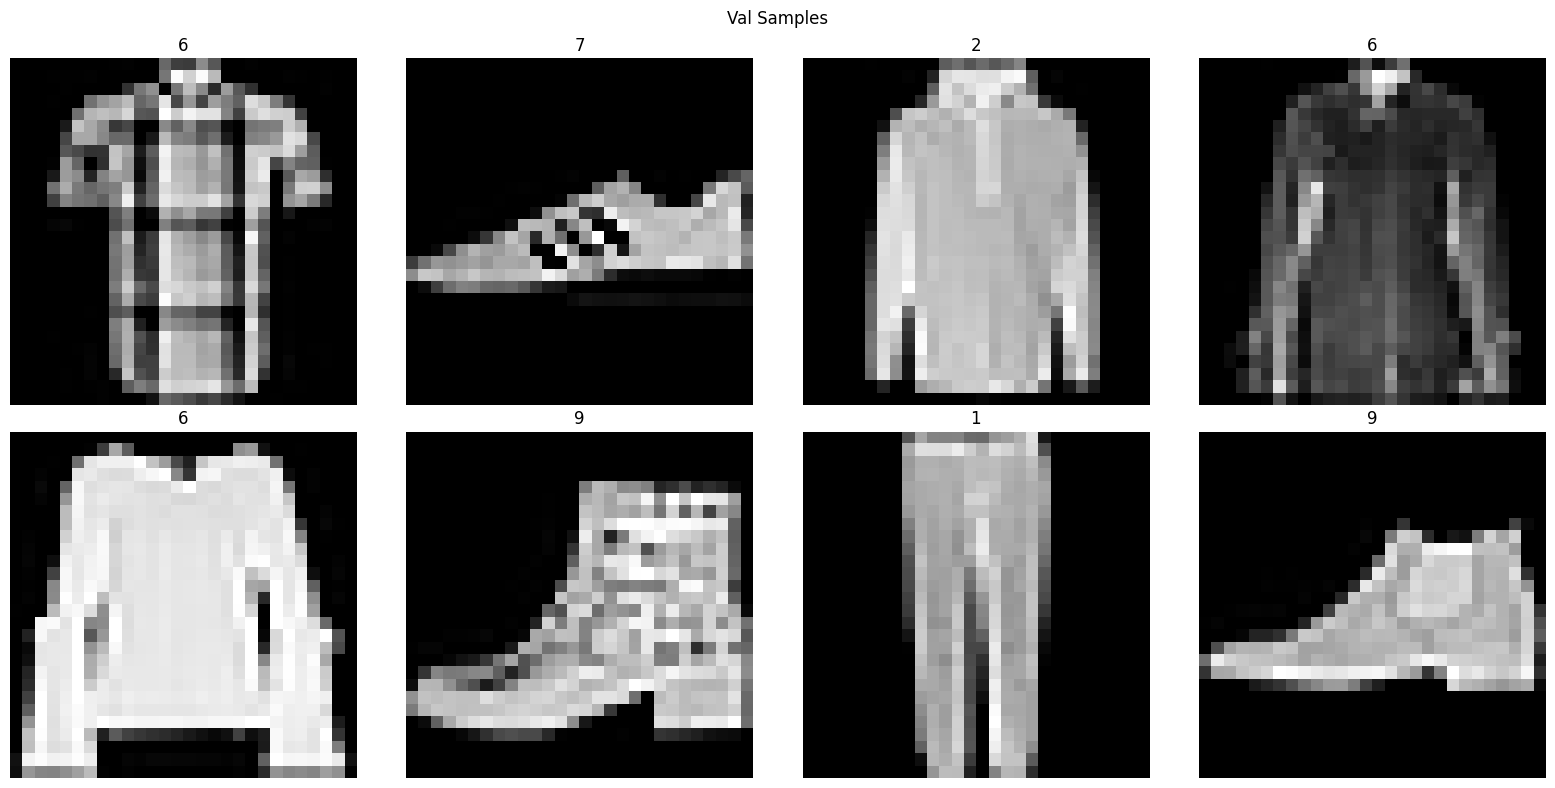

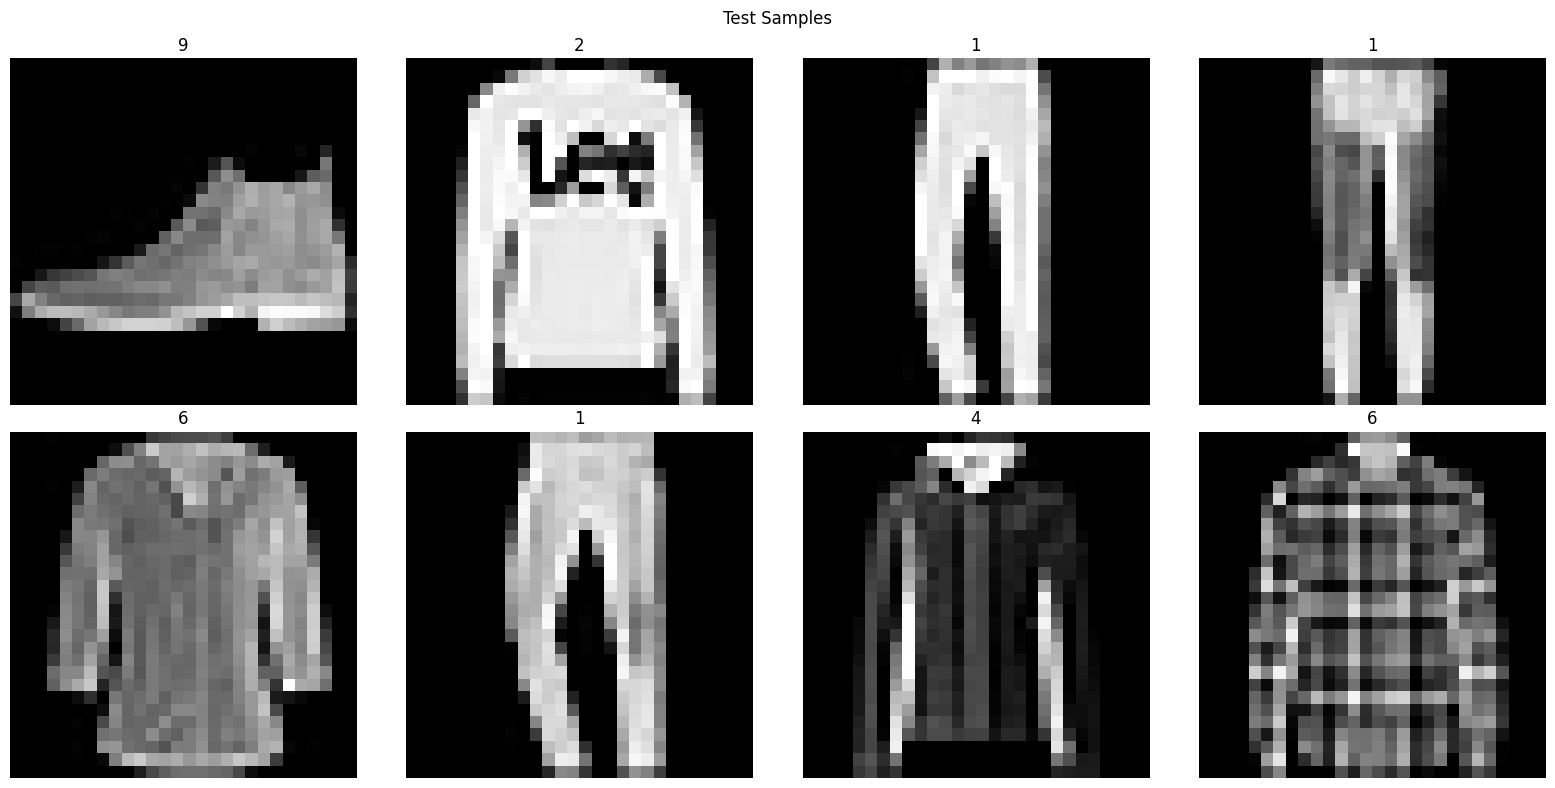

In [18]:
def get_transforms(augment=True):
    transforms = [ToTensor(), Normalize((0.2860,), (0.3530,))]
    if augment:
        transforms.insert(0, RandomHorizontalFlip(p=0.5))
        transforms.insert(0, RandomRotation(10))
    return Compose(transforms)

def show_samples(loader, title):
    images, labels = next(iter(loader))
    _, axes = plt.subplots(2, 4, figsize=(16, 8))
    for ax, img, label in zip(axes.ravel(), images[:18], labels[:18]):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(label.item())
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

full_training_set = FashionMNIST(
    root="./data",
    download=True,
    train=True,
    transform=get_transforms(augment=True))
testing_set = FashionMNIST(
    root="./data",
    download=True,
    train=False,
    transform=get_transforms(augment=False))

train_indices, val_indices = train_test_split(
    range(len(full_training_set)),
    test_size=VAL_SIZE,
    random_state=RANDOM_SEED,
    shuffle=True,
    stratify=full_training_set.targets.numpy())

training_set = Subset(full_training_set, train_indices)
validation_set = Subset(full_training_set, val_indices)
validation_set.dataset.transform = get_transforms(augment=False)

train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
val_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
test_loader = DataLoader(testing_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

print(f"Train: {len(training_set)}, Val: {len(validation_set)}, Test: {len(testing_set)}")
show_samples(train_loader, "Train Samples")
show_samples(val_loader, "Val Samples")
show_samples(test_loader, "Test Samples")

In [ ]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, 
                 weight_decay=0, amsgrad=False):
        defaults = dict(lr=lr, betas=betas, eps=eps, 
                       weight_decay=weight_decay, amsgrad=amsgrad)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                state = self.state[p]
                
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    if group['amsgrad']:
                        state['max_exp_avg_sq'] = torch.zeros_like(p)

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                state['step'] += 1
                beta1, beta2 = group['betas']

                state['exp_avg'].mul_(beta1).add_(grad, alpha=1-beta1)
                state['exp_avg_sq'].mul_(beta2).addcmul_(grad, grad, value=1-beta2)

                bias_corr1 = 1 - beta1 ** state['step']
                bias_corr2 = 1 - beta2 ** state['step']
                
                denom = (state['exp_avg_sq'].sqrt() / math.sqrt(bias_corr2)).add_(group['eps'])
                
                if group['amsgrad']:
                    torch.maximum(state['max_exp_avg_sq'], state['exp_avg_sq'], out=state['max_exp_avg_sq'])
                    denom = (state['max_exp_avg_sq'].sqrt() / math.sqrt(bias_corr2)).add_(group['eps'])

                step_size = group['lr'] / bias_corr1
                p.addcdiv_(state['exp_avg'], denom, value=-step_size)

        return loss

In [23]:
class ILayer(nn.Module, ABC):
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def backward(self, grad_output):
        pass

In [ ]:
class FullyConnected(ILayer):
    weight: nn.Parameter
    bias: nn.Parameter
    input: None | Any

    def __init__(self, in_features, out_features, dtype=torch.float32):
        super().__init__()
        self.weight = nn.Parameter(torch.empty((in_features, out_features), dtype=dtype))
        self.bias = nn.Parameter(torch.empty(out_features, dtype=dtype))
        self.input = None
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(self.bias, 0)
    
    def forward(self, x):
        self.input = x
        return x @ self.weight + self.bias
    
    def backward(self, grad_output):
        assert self.input != None

        grad_input = grad_output @ self.weight.T
        grad_weight = self.input.T @ grad_output
        grad_bias = grad_output.sum(dim=0)
        return grad_input, grad_weight, grad_bias

class Relu(ILayer):
    mask: Any | None

    def __init__(self):
        super().__init__()
        self.mask = None

    def forward(self, x):
        self.mask = x > 0
        return x * self.mask
    
    def backward(self, grad_output):
        assert self.mask != None

        return grad_output * self.mask

In [36]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=256, output_size=10, batch_norm=False):
        super().__init__()
        self.layers = nn.Sequential(
            FullyConnected(input_size, hidden_size),
            Relu(),
            nn.BatchNorm1d(hidden_size) if batch_norm else nn.Identity(),
            FullyConnected(hidden_size, output_size)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def backward(self, grad_output):
        grads = []
        current_grad = grad_output
        for layer in reversed(self.layers):
            if isinstance(layer, (FullyConnected, Relu)):
                current_grad = layer.backward(current_grad)
            elif isinstance(layer, nn.BatchNorm1d):
                pass
        return grads


class LitModel(L.LightningModule):
    def __init__(self, model_config, optim_config):
        super().__init__()
        self.save_hyperparameters()
        self.model = NeuralNetwork(
            hidden_size=model_config['hidden_size'],
            batch_norm=model_config['batch_norm']
        )
        self.optim_config = optim_config
        self.grad_check_interval = optim_config.get('grad_check_interval', 100)
        self.eps = 1e-4  # для численного расчета градиента

    def _validate_gradients(self, x, y):
        """Численная проверка градиентов с сохранением оригинальных значений"""
        original_params = {n: p.detach().clone() for n, p in self.model.named_parameters()}
        
        for name, param in self.model.named_parameters():
            if param.grad is None:
                continue
                
            analytic_grad = param.grad.data.clone()
            numerical_grad = torch.zeros_like(param.data)
            
            # Численный расчет градиента
            for i in range(param.numel()):
                # +eps
                param.data.view(-1)[i] += self.eps
                loss_plus = F.cross_entropy(self.model(x), y).item()
                
                # -eps
                param.data.view(-1)[i] -= 2 * self.eps
                loss_minus = F.cross_entropy(self.model(x), y).item()
                
                # Восстановление оригинального значения
                param.data.view(-1)[i] += self.eps
                
                # Центральная разностная производная
                numerical_grad.view(-1)[i] = (loss_plus - loss_minus) / (2 * self.eps)
            
            # Сравнение градиентов
            grad_diff = torch.norm(analytic_grad - numerical_grad) / (
                torch.norm(analytic_grad) + torch.norm(numerical_grad) + 1e-8)
            
            if grad_diff > 1e-3:
                print(f"WARNING: Large gradient difference in {name}: {grad_diff.item():.4f}")
        
        # Восстановление всех параметров
        for n, p in self.model.named_parameters():
            p.data.copy_(original_params[n])

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        
        if batch_idx % self.grad_check_interval == 0:
            self._validate_gradients(x, y)
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': loss, 'val_acc': acc})

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.model(x)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('test_acc', acc)

    def configure_optimizers(self):
        return Adam(
            self.parameters(),
            lr=self.optim_config['lr'],
            weight_decay=self.optim_config.get('weight_decay', 0)
        )

In [ ]:
# Конфигурация экспериментов
hp_grid = {
    'hidden_size': [100, 1000],
    'batch_norm': [False, True],
    'lr': [0.01, 0.001]
}

for h_size, bn, lr in itertools.product(*hp_grid.values()):
    print(f"\nTraining: hidden_size={h_size}, batch_norm={bn}, lr={lr}")
    
    model = LitModel(
        model_config={
            'hidden_size': h_size,
            'batch_norm': bn
        },
        optim_config={
            'lr': lr,
            'weight_decay': 0.005
        }
    )
    
    trainer = L.Trainer(
        max_epochs=3,
        accelerator="cpu",
        logger=L.loggers.CSVLogger("logs"),
        enable_checkpointing=False,
        enable_progress_bar=True
    )
    
    trainer.fit(model, train_loader, val_loader)
    trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | NeuralNetwork | 79.5 K | train
------------------------------------------------
79.5 K    Trainable params
0         Non-trainable params
79.5 K    Total params
0.318     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



Training: hidden_size=100, batch_norm=False, lr=0.01
Epoch 2: 100%|██████████| 750/750 [02:54<00:00,  4.29it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 750/750 [02:54<00:00,  4.29it/s, v_num=2]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kogora/AdiskD/PROG_SPBGU_HW/PROG_SPBU_3/ml-course/task-impls/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 148.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8052999973297119
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True



Training: hidden_size=100, batch_norm=False, lr=0.001


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | NeuralNetwork | 79.5 K | train
------------------------------------------------
79.5 K    Trainable params
0         Non-trainable params
79.5 K    Total params
0.318     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 2: 100%|██████████| 750/750 [02:52<00:00,  4.35it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 750/750 [02:52<00:00,  4.35it/s, v_num=3]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 131.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.84579998254776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training: hidden_size=100, batch_norm=True, lr=0.01


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | NeuralNetwork | 79.7 K | train
------------------------------------------------
79.7 K    Trainable params
0         Non-trainable params
79.7 K    Total params
0.319     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 1:  53%|█████▎    | 400/750 [01:38<01:25,  4.08it/s, v_num=4]